
# Repurposing masks into bounding boxes

The following example illustrates the operations available
the `torchvision.ops <ops>` module for repurposing
segmentation masks into object localization annotations for different tasks
(e.g. transforming masks used by instance and panoptic segmentation
methods into bounding boxes used by object detection methods).


In [1]:
# sphinx_gallery_thumbnail_path = "../../gallery/assets/repurposing_annotations_thumbnail.png"

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision.transforms.functional as F


ASSETS_DIRECTORY = Path.cwd()

plt.rcParams["savefig.bbox"] = "tight"

## Masks
In tasks like instance and panoptic segmentation, masks are commonly defined, and are defined by this package,
as a multi-dimensional array (e.g. a NumPy array or a PyTorch tensor) with the following shape:

      (num_objects, height, width)

Where num_objects is the number of annotated objects in the image. Each (height, width) object corresponds to exactly
one object. For example, if your input image has the dimensions 224 x 224 and has four annotated objects the shape
of your masks annotation has the following shape:

      (4, 224, 224).

A nice property of masks is that they can be easily repurposed to be used in methods to solve a variety of object
localization tasks.



## Converting Masks to Bounding Boxes
For example, the :func:`~torchvision.ops.masks_to_boxes` operation can be used to
transform masks into bounding boxes that can be
used as input to detection models such as FasterRCNN and RetinaNet.
We will take images and masks from the `PenFudan Dataset <https://www.cis.upenn.edu/~jshi/ped_html/>`_.



In [2]:
from torchvision.io import read_image

img_path = os.path.join(ASSETS_DIRECTORY, "FudanPed00054.png")
mask_path = os.path.join(ASSETS_DIRECTORY, "FudanPed00054_mask8bit.png")
img = read_image(img_path)
mask = read_image(mask_path)

Here the masks are represented as a PNG Image, with floating point values.
Each pixel is encoded as different colors, with 0 being background.
Notice that the spatial dimensions of image and mask match.



In [3]:
print(mask.size())
print(img.size())


torch.Size([1, 498, 533])
torch.Size([3, 498, 533])


In [4]:
# We get the unique colors, as these would be the object ids.
obj_ids = torch.unique(mask)
obj_ids

tensor([ 43,  48, 154, 159], dtype=torch.uint8)

In [5]:
# first id is the background, so remove it.
# in my version of the dataset, the background is the second object id
obj_ids = obj_ids[[True, False, True, True]]
obj_ids

tensor([ 43, 154, 159], dtype=torch.uint8)

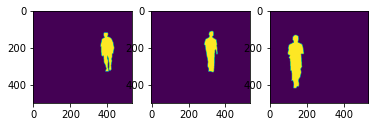

In [6]:
# import plt
import matplotlib.pyplot as plt
# split the color-encoded mask into a set of boolean masks.
# Note that this snippet would work as well if the masks were float values instead of ints.
masks = mask == obj_ids[:, None, None]
fig, axs = plt.subplots(nrows=1,ncols=masks.shape[0])
for i in range(masks.shape[0]):
    axs[i].imshow(masks[i])

Now the masks are a boolean tensor.
The first dimension in this case 3 and denotes the number of instances: there are 3 people in the image.
The other two dimensions are height and width, which are equal to the dimensions of the image.
For each instance, the boolean tensors represent if the particular pixel
belongs to the segmentation mask of the image.



In [7]:
print(masks.size())

torch.Size([3, 498, 533])


Let us visualize an image and plot its corresponding segmentation masks.
We will use the :func:`~torchvision.utils.draw_segmentation_masks` to draw the segmentation masks.



In [8]:
from torchvision.utils import draw_segmentation_masks

drawn_masks = []
for mask in masks:
    drawn_masks.append(draw_segmentation_masks(img, mask, alpha=0.8, colors="blue"))

len(drawn_masks)

3

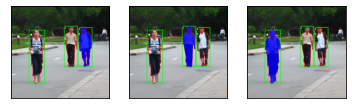

In [9]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(drawn_masks)

To convert the boolean masks into bounding boxes.
We will use the :func:`~torchvision.ops.masks_to_boxes` from the torchvision.ops module
It returns the boxes in ``(xmin, ymin, xmax, ymax)`` format.



In [10]:
from torchvision.ops import masks_to_boxes

boxes = masks_to_boxes(masks)
print(boxes.size())
print(boxes)

torch.Size([3, 4])
tensor([[363., 120., 436., 328.],
        [286., 113., 357., 331.],
        [ 96., 134., 181., 417.]])


As the shape denotes, there are 3 boxes and in ``(xmin, ymin, xmax, ymax)`` format.
These can be visualized very easily with :func:`~torchvision.utils.draw_bounding_boxes` utility
provided in `torchvision.utils <utils>`.



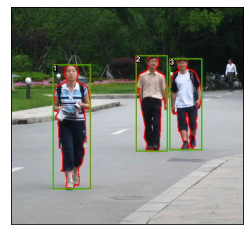

In [11]:
from torchvision.utils import draw_bounding_boxes

drawn_boxes = draw_bounding_boxes(img, boxes, colors="red")
show(drawn_boxes)

These boxes can now directly be used by detection models in torchvision.
Here is demo with a Faster R-CNN model loaded from
:func:`~torchvision.models.detection.fasterrcnn_resnet50_fpn`



In [12]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
print(img.size())

tranforms = weights.transforms()
img = tranforms(img)
target = {}
target["boxes"] = boxes
target["labels"] = labels = torch.ones((masks.size(0),), dtype=torch.int64)
detection_outputs = model(img.unsqueeze(0), [target])

ImportError: cannot import name 'FasterRCNN_ResNet50_FPN_Weights' from 'torchvision.models.detection' (/Users/bementmbp/opt/anaconda3/envs/pytorch-tutorial/lib/python3.10/site-packages/torchvision/models/detection/__init__.py)

## Converting Segmentation Dataset to Detection Dataset

With this utility it becomes very simple to convert a segmentation dataset to a detection dataset.
With this we can now use a segmentation dataset to train a detection model.
One can similarly convert panoptic dataset to detection dataset.
Here is an example where we re-purpose the dataset from the
`PenFudan Detection Tutorial <https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html>`_.



In [ ]:
class SegmentationToDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = read_image(img_path)
        mask = read_image(mask_path)

        img = F.convert_image_dtype(img, dtype=torch.float)
        mask = F.convert_image_dtype(mask, dtype=torch.float)

        # We get the unique colors, as these would be the object ids.
        obj_ids = torch.unique(mask)

        # first id is the background, so remove it.
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set of boolean masks.
        masks = mask == obj_ids[:, None, None]

        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((masks.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target